## Data Exploration

In [1]:
#-----------------------------------packages-----------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

pd.set_option('display.max_columns', None)

### Data Cleaning

In [2]:
#-------------------------load data and assess quality-------------------------
data = pd.read_table('data/XYZCorp_LendingData.txt', low_memory = False,
                     parse_dates = ['issue_d', 'last_pymnt_d', 'next_pymnt_d',
                                    'earliest_cr_line', 'last_credit_pull_d'])

nan_props = data.isna().sum()/len(data)
print(nan_props[nan_props > 0].sort_values())

title                          0.000039
last_credit_pull_d             0.000058
collections_12_mths_ex_med     0.000065
revol_util                     0.000521
last_pymnt_d                   0.010353
emp_length                     0.050307
emp_title                      0.057763
total_rev_hi_lim               0.078640
tot_cur_bal                    0.078640
tot_coll_amt                   0.078640
next_pymnt_d                   0.295538
mths_since_last_delinq         0.513818
mths_since_last_major_derog    0.750997
mths_since_last_record         0.846742
desc                           0.857691
inq_fi                         0.984476
all_util                       0.984476
max_bal_bc                     0.984476
open_rv_24m                    0.984476
open_rv_12m                    0.984476
total_bal_il                   0.984476
open_il_24m                    0.984476
open_il_12m                    0.984476
open_il_6m                     0.984476
open_acc_6m                    0.984476


We begin by analysing columns with NaN any values. Columns fall into two categories here: those that have NaN due to missing data and those that have NaN due to the column being unapplicable for the borrower. For example we would expect each borrower to have entered <i>'emp_title'</i> but it is possible that a borrower has never been delinquent, giving a NaN in <i>'mths_since_last_delinq'</i>.

The following columns contain at least one NaN value:

In [3]:
nan_cols = nan_props[nan_props > 0].index
print(nan_cols)

Index(['emp_title', 'emp_length', 'desc', 'title', 'mths_since_last_delinq',
       'mths_since_last_record', 'revol_util', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m'],
      dtype='object')


We first consider the employment columns: <i>'emp_title'</i> and <i>'emp_length'</i>. Observe that there are $290812$ categories in this column. In order to use this as a feature, we amalgamate any category with less than $100$ entries and any NaN values into an <i>other</i> category. We could combine these categories in a smarter way by considering each entry and where it best fits into the larger categories and distributing the NaN values proportionately, but we will keep things simple for now. As the employment length is made up of categories in $\{\text{`Unknown'},\text{ NaN}\} \cup \mathbb{N}$, we fill the NaN values with the median.

In [4]:
#---------------------------employment data cleaning---------------------------
data['emp_length'] = data[data['emp_length'] !=
     'Unknown']['emp_length'].str.replace('[a-z+< ]', '', regex = True)
data['emp_length'].fillna(data['emp_length'].median(), inplace = True)

emp_categories = data['emp_title'].value_counts()
data.loc[~data['emp_title'].isin(
         emp_categories[emp_categories > 100].index), 'emp_title'] = 'Other'

For the columns relating to months since an event, we replace the NaN values with $-1$ and add a new column flagging the existence of these events. For those columns counting the occurences of events in certain time periods, we replace NaN values with the median.

In [5]:
#-------------------------event occurence data cleaning------------------------
month_cols = ['mths_since_last_delinq', 'mths_since_last_record',
              'mths_since_last_major_derog']

data.fillna({col: -1 for col in month_cols}, inplace = True)
for col in month_cols:
    data[col + '_flag'] = data[col] != -1

occurence_cols = ['collections_12_mths_ex_med', 'open_acc_6m', 'open_il_6m',
                  'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
                  'open_rv_12m', 'open_rv_24m', 'inq_last_12m']

data.fillna(data[occurence_cols].median().to_dict(), inplace = True)

We only need the <i>'desc'</i> column for the NLP and so we can ignore the NaN values for now. The information in the the <i>'title'</i> column can be accessed more readily through the <i>'purpose'</i> column so we can drop this.

The rest of the below columns have over $98\%$ NaN values and so we drop these for simplicity.

In [6]:
#-------------------removing columns with too many NaN values------------------
data.drop(['all_util', 'max_bal_bc', 'total_cu_tl', 'inq_fi', 'total_bal_il',
           'il_util', 'annual_inc_joint', 'verification_status_joint',
           'dti_joint', 'title'], axis = 1, inplace = True)

For the date columns, we can see that the data is heavily concetrated around one value, so we replace the NaN values with the mode.

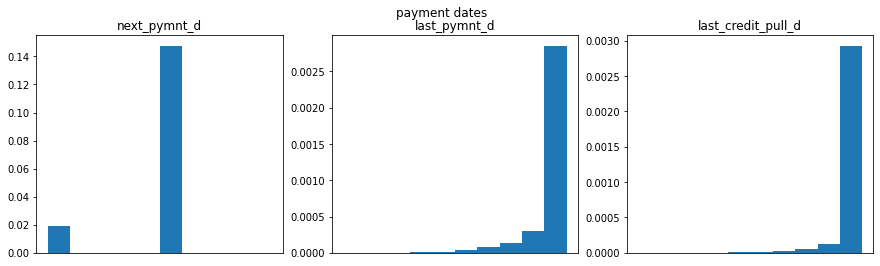

In [7]:
#------------------------------date data cleaning------------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
for n, col in enumerate(['next_pymnt_d', 'last_pymnt_d',
                         'last_credit_pull_d']):
    axs[n].hist(data[col], density = True)
    axs[n].title.set_text(col)
    axs[n].xaxis.set_visible(False)

fig.suptitle('payment dates')
plt.show

data.fillna(data[['next_pymnt_d', 'last_pymnt_d',
                  'last_credit_pull_d']].mode().iloc[0].to_dict(),
            inplace = True)

For the remaining columns, we replace NaN values with the median as it is robust to outliers.

In [8]:
#-------------------limits, balances and utlisation cleaning-------------------
data.fillna(data[['revol_util', 'tot_coll_amt',
                  'tot_cur_bal', 'total_rev_hi_lim']].median().to_dict(),
            inplace = True)

We now check for remaining NaN values and save the dataset that will be used for the NLP.

In [9]:
#-----------------check for NaN values and save cleaned dataset----------------
data[['desc', 'purpose']].dropna().to_csv('data/nlp_data.csv', index = False)
data.drop('desc', axis = 1, inplace = True)

nan_props = data.isna().sum()/len(data)
print(nan_props[nan_props > 0].sort_values())

Series([], dtype: float64)


### Column Selection

We filter the dataset for individual policyholders as we previously dropped the joint policyholder information and drop the <i>'policy_code'</i> and <i>'application_type'</i> columns as each column only contains $1$ value.

We can also drop columns which will not be relevant to any modelling such as <i>'id'</i> and <i>'member_id'</i>.

In [10]:
#----------------------dropping heavily one-sided columns----------------------
data = data[data['application_type'] == 'INDIVIDUAL']
data.drop(['policy_code', 'application_type',
            'id', 'member_id'], axis = 1, inplace = True)

In order to pass date data to any models, we will combine them in a number of ways to yield durations in days. For example, <i>last_pymnt_dt</i> will be converted to days between <i>last_pymnt_dt</i> and <i>issue_d</i>.

In [11]:
#---------------------converting date columns to durations---------------------
data['last_pymnt_days'] = (data['last_pymnt_d'] - data['issue_d']).dt.days

data['days_to_nxt_pymnt'] = (data['next_pymnt_d'] -
                             data['last_pymnt_d']).dt.days

data['last_credit_pull_days'] = (data['last_credit_pull_d'] -
                                 data['issue_d']).dt.days

data['days_after_first_credit'] = (data['issue_d'] -
                                   data['earliest_cr_line']).dt.days

data['issue_days'] = (data['issue_d'] - dt.datetime(2000, 1, 1)).dt.days

data.drop(['last_pymnt_d', 'issue_d', 'next_pymnt_d', 'last_credit_pull_d',
           'earliest_cr_line'], axis = 1, inplace = True)

### Outliers

### Correlation

We assess the correlation of features with the target column to ensure that we aren't passing any features to our $X$ data that are completely correlated to the target $y$ data.

In [12]:
#----------------------observing highly correlated columns---------------------
data_corr = (data.select_dtypes(include = np.number) > 0).copy().corr()

data_corr.corr()[['recoveries', 'default_ind']].sort_values(
                 ['recoveries', 'default_ind'], ascending = False).head()

,recoveries,default_ind
recoveries,1.000000,0.946281
collection_recovery_fee,0.999688,0.942494
default_ind,0.946281,1.000000
total_rec_late_fee,0.302127,0.341742
days_to_nxt_pymnt,0.111773,0.145368


Finally, we save $3$ csv files for classification, regression and clustering (which is also the general file).

In [13]:
#--------------------------------saving csv files------------------------------
data.to_csv('data/data.csv', index = False)

data.drop(['recoveries', 'collection_recovery_fee',
           'total_rec_late_fee'], axis = 1).to_csv('data/class_data.csv',
                                                   index = False)
data.drop(['default_ind', 'collection_recovery_fee',
           'total_rec_late_fee'], axis = 1).to_csv('data/reg_data.csv',
                                                   index = False)